<a href="https://colab.research.google.com/github/Fluffy96/AdverserialAttack/blob/main/AdverserialAttacksOnCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time


Below we are defining the size of the graphs to be created fo displaying images

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# Classification Method
We will be importing an image classifier here the befit being that the we can work with a stronger preexsisting model called MobileNetV2 which already contains 1000 classifications.

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False# prevent the weights of the pre-trained model from being updated during training
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions


## Adding in helper functions to help with uploading images and preprocessing

In [ ]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

# Step 1 Import Your own image and use the preprocess function from before and project the image and its confidence


1/1 [==============================] - 2s 2s/step


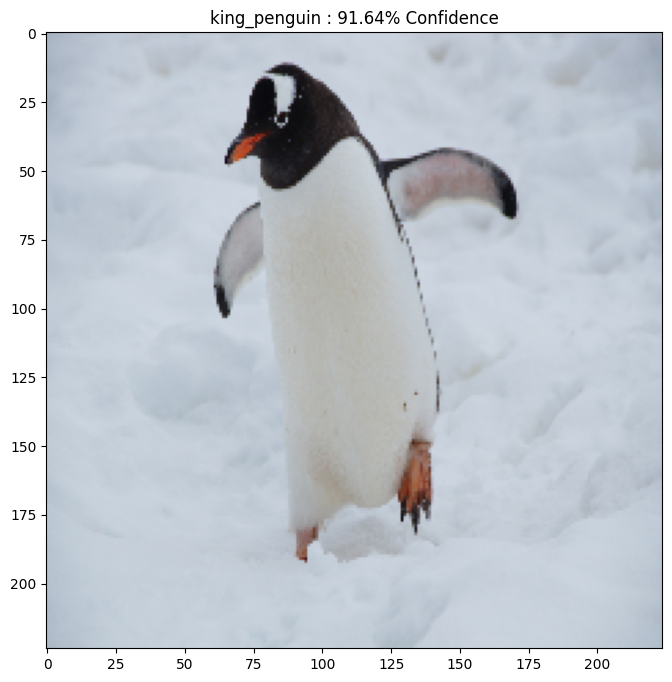

In [ ]:
image_path = '/content/penguin.jpg'# replace this with your own path to the image you want

# read in the image data
image_raw = tf.io.read_file(image_path)

# decode the image data into a tensor
image = tf.image.decode_image(image_raw)

# preprocess the image
image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Print out the image using matplotlib and label image with confidence
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

#Step 2 We will now generate the adverserial image using FGSM method

Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximizes the loss. So in simpler words the method works by taking the loss function of a specific image and then optimizing the loss function for greater loss therefore either misclassifying the image as something else entirely or decreasing the confidence in the image. The mathematical equation is defined as: $$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the noise added is small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

The objective is to find how much each pixel in the image contributes to the loss value and adding noise to it. The more aggressive you run the algorithm the more pixel you change.


In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the noise
  signed_grad = tf.sign(gradient)
  return signed_grad

## Plot the noise image so that we can visualize it below
Please confirm that the image was classified correctly if it was not you should use a different image or google what index for your images classification is

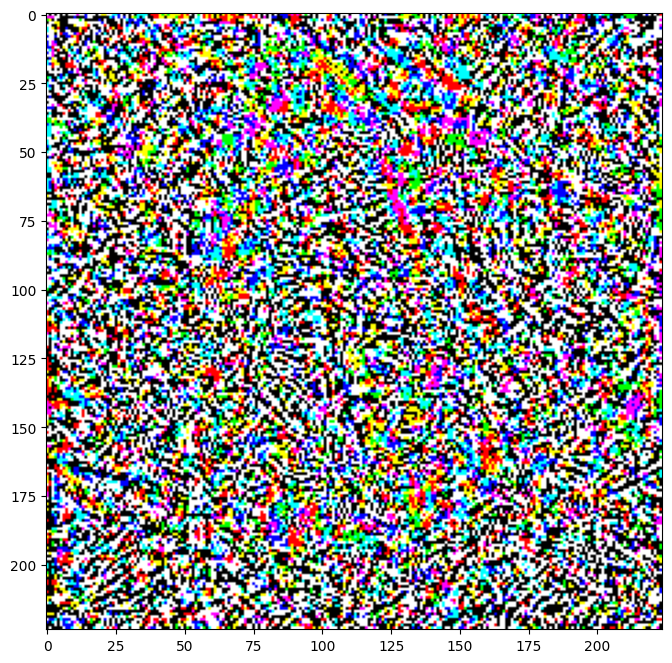

In [ ]:
predicted_class_index = tf.argmax(image_probs, axis=-1)[0]
label = tf.one_hot(predicted_class_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

noise = create_adversarial_pattern(image, label)
plt.imshow(noise[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1] this is important

##Lets add the noise we created above to the image but at a couple different epsilons to see what happens to the confidence when we add varrying percents of the nose we generated above

1/1 [==============================] - 0s 61ms/step


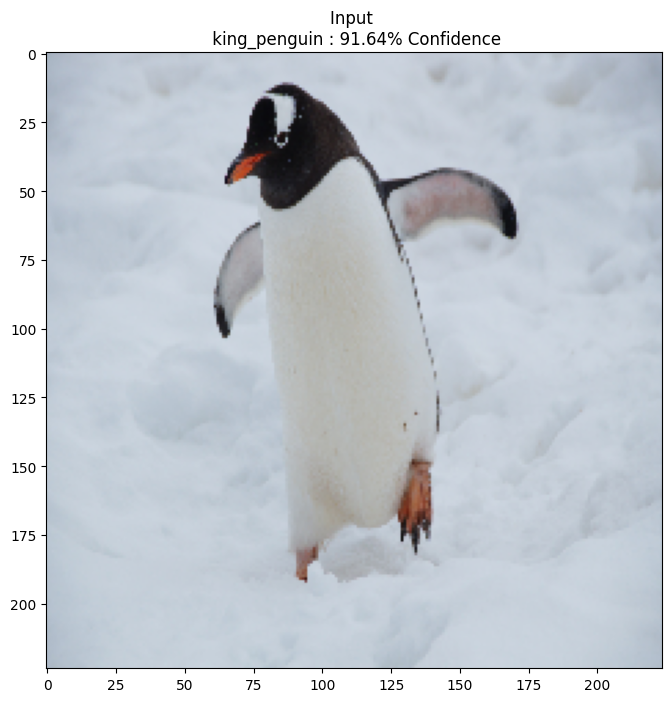

Time taken:  0.14452600479125977 seconds
1/1 [==============================] - 0s 92ms/step


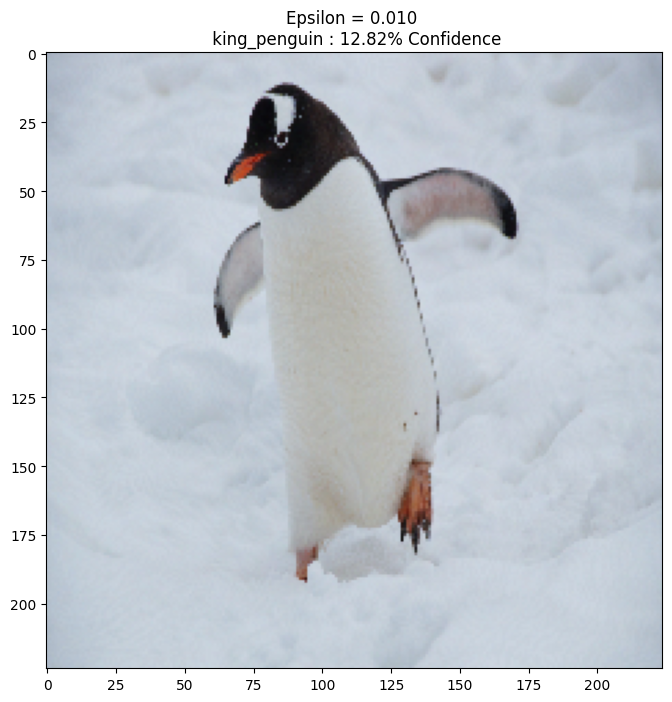

Time taken:  0.1967017650604248 seconds
1/1 [==============================] - 0s 89ms/step


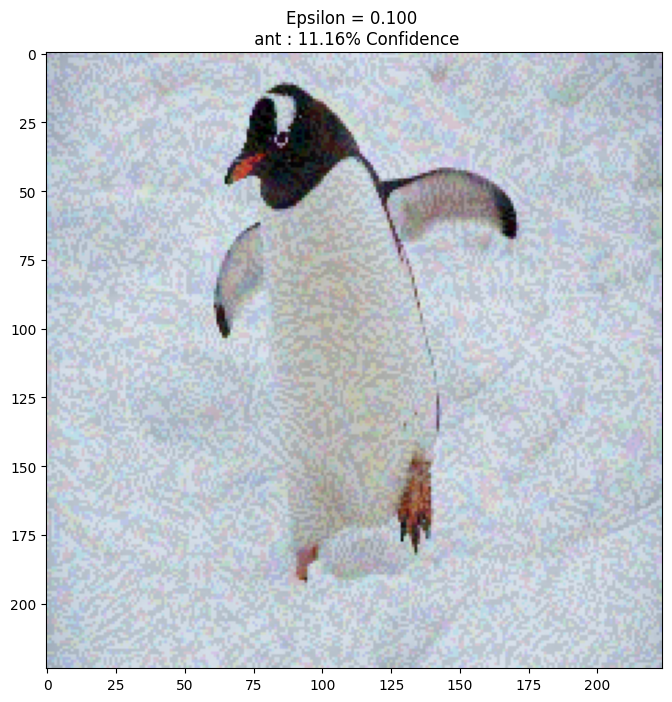

Time taken:  0.16840410232543945 seconds
1/1 [==============================] - 0s 103ms/step


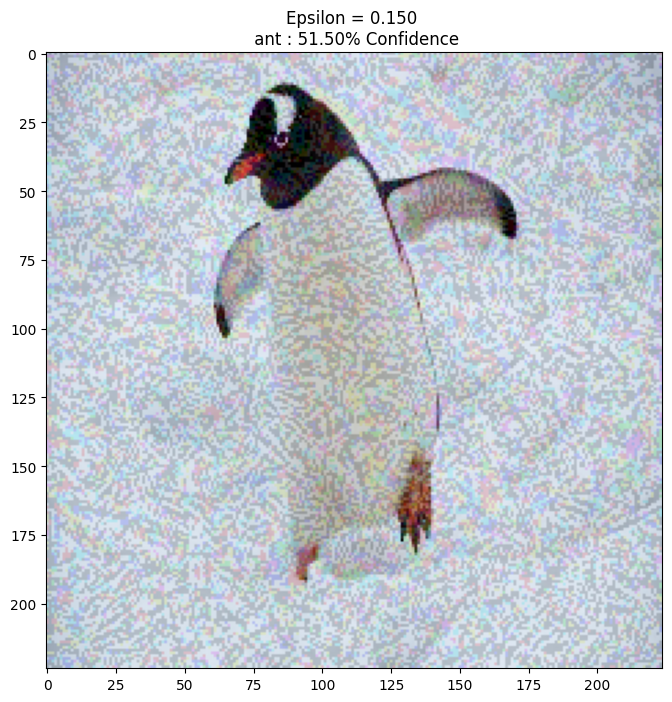

Time taken:  0.1860334873199463 seconds


In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]


for i, eps in enumerate(epsilons):
  adv_x = image + eps*noise
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  start_time = time.time()
  _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
  end_time = time.time()
  plt.figure()
  plt.imshow(adv_x[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[i] ,
                                                   label, confidence*100))
  plt.show();
  print("Time taken: ", end_time - start_time, "seconds")

# Step 3 We will repeat the above but now with PGD

PGD is almost a guess and check because the whole point of it is to iteratively takes small steps in the direction of the gradient of the loss function in hopes to get to higher loss. This process is repeated multiple times to generate a stronger noise that is harder for defenses to detect. it is able to generaate stronger and harder to detect noise at the cost of being computationally heavy.<br>
Use http://www.image-net.org/ to find the index of ur image

### Model setup and uploading image


In [ ]:
model = tf.keras.applications.MobileNetV2(weights='imagenet')
image_path = '/content/penguin.jpg'# replace this with your own path to the image you want
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)



### PGD Attack code


In [ ]:
def pgd_attack(model, x, y, eps, alpha, num_steps, clip_min, clip_max):
    x_adv = tf.identity(x)
    for i in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            loss = tf.keras.losses.categorical_crossentropy(y, model(x_adv))
        gradient = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(gradient)  # add noise to the input in direction of sign(gradient)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)  # clip input to ensure valid pixel values
        x_adv = tf.clip_by_value(x_adv, x - eps, x + eps)  # clip input to ensure noise budget
        x_adv = tf.cast(x_adv, tf.float32)
    return x_adv

In [ ]:
def get_imagenet_label(img):
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    preds = model.predict(img)
    label = tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=1)[0][0]
    return label[1], label[2]

### Attack Parameters and Generating adverserial example using pgd

1/1 [==============================] - 0s 81ms/step


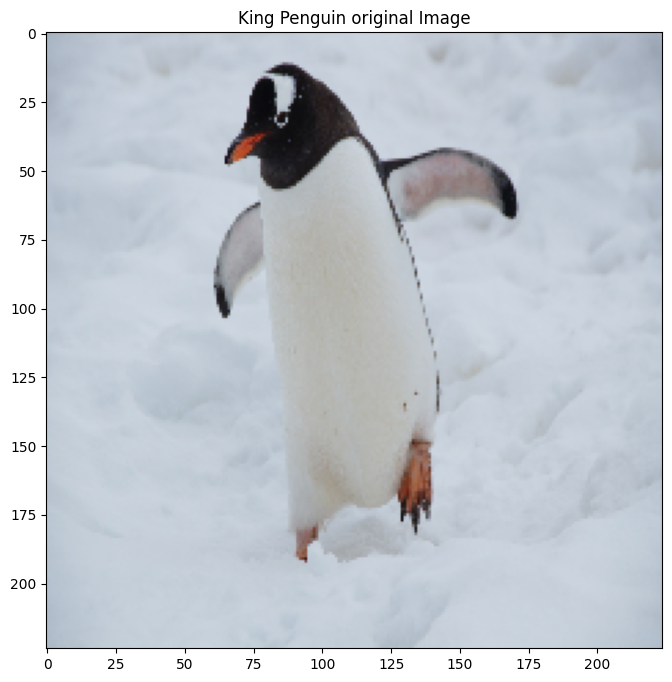

1/1 [==============================] - 0s 69ms/step


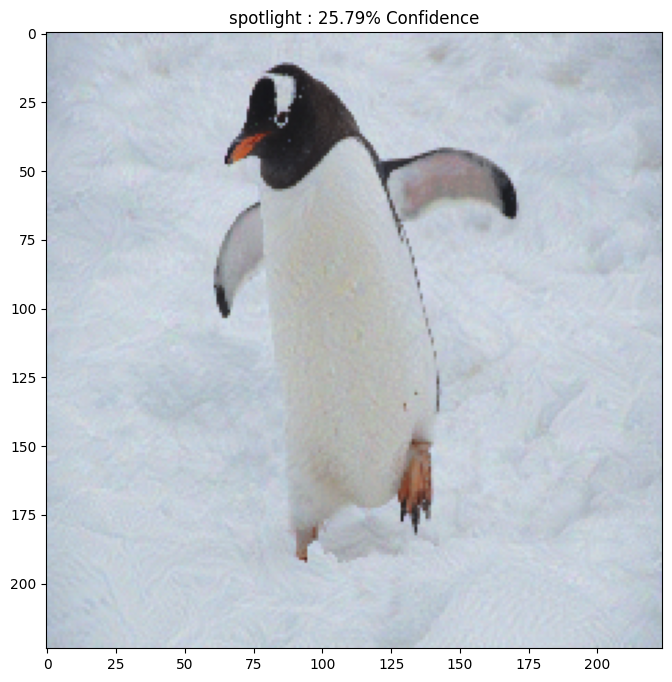

Time taken:  5.084847450256348 seconds


In [ ]:
# Define PGD attack parameters
eps = 0.1  # perturbation budget
alpha = 0.01  # step size
num_steps = 10  # number of iterations mae this larger to get a better noise file
clip_min = 0.0  # minimum pixel value
clip_max = 255.0  # maximum pixel value

# Generate PGD adversarial example
true_label = 654 # THIS IS FOR THE KING PENGUIN USE WEBSITE ABOVE TO FIND THE ONE LINKED TO YOUR IMAGE
y_true = tf.one_hot([true_label], 1000)
start_time = time.time()

x_adv = pgd_attack(model, image, y_true, eps, alpha, num_steps, clip_min, clip_max)
end_time = time.time()


plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
image_class, class_confidence = get_imagenet_label(x_adv)
plt.title("King Penguin original Image")
plt.show()

plt.figure()
plt.imshow(x_adv[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
image_class, class_confidence = get_imagenet_label(x_adv)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))

plt.show()
print("Time taken: ", end_time - start_time, "seconds")

# Step 4 Analysis Plus Solutions
1) In my opinion the minor changes that pgd makes itteratively looks more real to the naked eye compared to the examples generated by FGSM therfore making PGD the better attack however FGSM is a much faster attack to conduct compared to PGD iterative apporach